## 2.6 Building model with Deep Learning

## Using Tensorflow to build model

### Isolating Rossmann Store Sales dataset into time series data

In [12]:
# Importing Necessary Packages
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime
from pandas import Series,DataFrame
from sklearn.preprocessing import MinMaxScaler

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Setting Logging

In [2]:
import logging
import logging.handlers
import os
 
handler = logging.handlers.WatchedFileHandler(
    os.environ.get("LOGFILE", "../logs/deep_learning.log"))
formatter = logging.Formatter(logging.BASIC_FORMAT)
handler.setFormatter(formatter)
root = logging.getLogger()
root.setLevel(os.environ.get("LOGLEVEL", "INFO"))
root.addHandler(handler)
logging.info("Testing Loggings") 
try:
    exit(main())
except Exception:
    logging.exception("Exception in main()")
    exit(1)

In [5]:
# Class to load the data
class FetchData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['store'] = self.get_store_data()
        
    def get_train_data(self,name='train'):
        filename = f'../data/{name}.csv'
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None
    
    def get_test_data(self,name='test'):
        filename = f'../data/{name}.csv'        
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully")
            return df   

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None
        
    def get_store_data(self,name='store'):
        filename = f'../data/{name}.csv'        
        try:
            df = pd.read_csv(filename)
            logging.info(f"{name} Dataset read successfully") 
            return df  

        except Exception as e:
            logging.exception(f" Exception occured in reading dataset, {e}")
            return None 

In [7]:
data = FetchData()


In [8]:
try:
    train_data = data.get_train_data("train")
    train_store_data = data.get_train_data("train_store_data")
    test_data = data.get_train_data("test")

except Exception as e:
    logging.exception(f"Exception occured in loading dataset, Exception:{e}")

In [17]:
# temp_train_store_data.sample(4)
rossmann_store_sales = pd.DataFrame()
rossmann_store_sales['Date'] = train_data['Date']
rossmann_store_sales['Sales'] = train_data['Sales']
rossmann_store_sales.sample(4)

,Date,Sales
349726,2014-09-01,8533
481625,2014-04-26,6971
372709,2014-08-08,10509
612894,2013-12-29,0


In [18]:
scaler = MinMaxScaler()
try:
    
    scale = scaler.fit(rossmann_store_sales[['Sales']]) 
    # transform the training data column
    rossmann_store_sales['Scaled_sales'] = scale.transform(rossmann_store_sales[['Sales']])
    logging.info(f"Changing non-numeric to numeric values, successfully")

except Exception as e:
    print(e)
    logging.exception(f"Exception occured while changing non-numeric to numeric values, Exception:{e}")

In [19]:
rossmann_store_sales.sample(4)

,Date,Sales,Scaled_sales
70572,2015-05-29,5024,0.120912
118193,2015-04-16,9818,0.236288
869105,2013-05-13,8262,0.198840
905137,2013-04-11,3763,0.090563


### Checking for Stationality

### Step 1: Check Stationarity Before going any further into our analysis, our series has to be made stationary.
 - Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation etc). if the mean of a tm increases over time, then it not stationary.

### The mean across many time periods is only informative if the expected value is the same across time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

### Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.
### Methods to Check Stationarity
 ### 1 Plotting rolling statistics: plotting rolling mean and variance is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not stationary.

 ### 2 ACF and PACF plots: An autocorrelation plot (ACF) represent the autocorrelation of the series with lags of itself. A partialACF plot represent the amount of correlation beetween a series and a lag of itself that is not explained by correlations at all lower-order lags Ideally, we want no corralation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

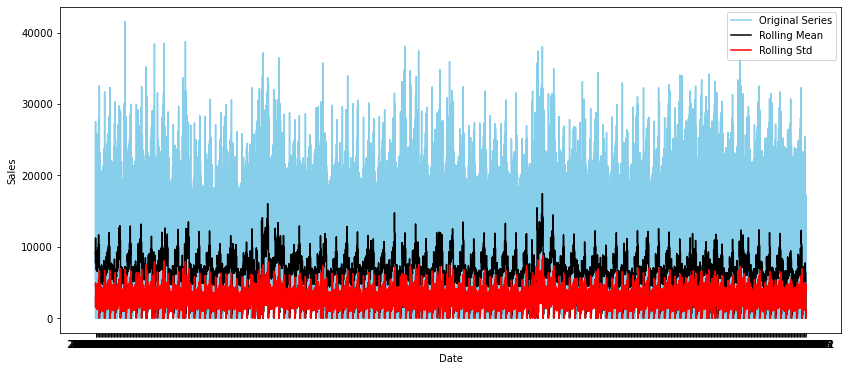

In [20]:
# rossmann_store_sales.plot()
rossmann_df = rossmann_store_sales[['Date', 'Sales']].set_index('Date')

def test_stationarity(tm):
    # plotting rolling statistics
    rollmean = tm.rolling(window=30).mean()
    rollstd = tm.rolling(window=30).std()
    
    plt.figure(figsize=(14, 6))
    plt.plot(tm, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')    
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(tm, autolag='AIC')
    print('Test Statistics = {:.3f}'.format(adfuller_test[0]))
    print('P-value = {:.3f}'.format(adfuller_test[1]))
    print('Critical values :')
    # for key, value in adfuller_test[4].items():
    #     print('\t{}: {} - The data is {} stationary with {}% confidence'.format(key, value,'' if adfuller_test[0] < value else 'not', 100 - int(key[:-1])))    
    fig, ax = plt.subplots(2, figsize=(14,6))
    ax[0] = plot_acf(tm, ax=ax[0], lags=20)
    ax[1] = plot_pacf(tm, ax=ax[1], lags=20)

test_stationarity(rossmann_df.Sales)

### From the figure it can be deduced that, mean and standar deviation are almost 

In [1]:
adfResult = adfuller(rossmann_store_sales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

NameError: name 'adfuller' is not defined

### Transform the time series data into supervised learning data by creating a new y(target) column. For example as illustrated here in the Sliding Window For Time Series Data section